<a href="https://colab.research.google.com/github/zsteve/wtf/blob/main/examples/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# setup git
!git clone https://github.com/zsteve/wtf
!pip install tensorly
!pip install pot
!pip install gwot

In [1]:
PLT_CELL = 2.5
figs_path = "/home/zsteve/wtf/manuscript/figs/"

In [2]:
import sys
sys.path.insert(0, "/home/zsteve/wtf/src")
import wtf

In [3]:
import numpy as np
import copy
import tensorly as tl
from tensorly import tenalg, decomposition, cp_tensor
from tensorly.contrib.sparse import tensor as sptensor
import ot
import torch
import sklearn 
from sklearn import datasets
import matplotlib.pyplot as plt
tl.set_backend("pytorch")
torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tl_dtype = tl.float64

In [4]:
# import matplotlib
# font = {'family' : 'normal',
#         'size'   : 12}
# matplotlib.rc('font', **font)

In [5]:
def gaussian(x, h):
    return np.exp(-(x/h)**2)

def gen_img(x0, x1, h = 0.25, r0 = 0.1, r1 = 0.1):
    x = np.linspace(-1., 1., 32)
    alpha = gaussian(x - x0 + r0*np.random.normal(), h)
    beta = gaussian(x - x1 + r1*np.random.normal(), h)
    return alpha, beta

sizex, sizey = (32, 32)

N = 100
factors1 = [gen_img(0, 0, h = 0.3, r0 = 0.15, r1 = 0.05) for x in range(N)]
factors2 = [gen_img(0.5, 0.5, h = 0.2, r0 = 0.15,r1 = 0.1) for x in range(N)]
factors3 = [gen_img(-0.5, -0.5, h = 0.15, r0 = 0.15, r1 = 0.15) for x in range(N)]

def outer(x):
    return np.outer(x[0], x[1])

X = tl.tensor([wtf.normalise(outer(factors1[i]) + outer(factors2[i]) + outer(factors3[i])) for i in range(N)], dtype = tl_dtype)

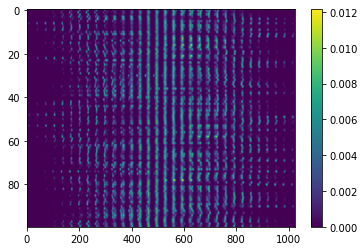

In [6]:
plt.imshow(tl.unfold(X, 0))
plt.axis("auto")
plt.colorbar()

In [7]:
xx, yy = np.meshgrid(range(sizex), range(sizey))
coords = np.vstack((xx.reshape(1, sizex*sizey), yy.reshape(1, sizex*sizey))).T
C_full = ot.utils.euclidean_distances(coords, coords, squared=True)
C_full = torch.Tensor(C_full/C_full.mean()).to(device)

In [8]:
# save SWIFT version
# idx = np.array(np.where(X > 0)).T
# vals = np.ones(idx.shape[0])
# vals = vals/vals.sum()
#  
# out = np.hstack([idx, vals.reshape(-1, 1)])
# out[:, 0] += 1
# 
# C = ot.utils.euclidean_distances(xx, xx, squared = True)
# C = C/C.mean()
# np.savetxt("X_slice.csv", out)
# np.savetxt("C_slice.csv", C)
# np.savetxt("C_images.csv", C_images)
# np.save("X_slice.npy", X)

In [9]:
# now pick multilinear rank
d = 3
r = [3, ]*3
S = tl.zeros(r).to(device)
for i in range(r[0]):
    S[i, i, i] = 1

# initialise using SVD
factor_cp = tl.decomposition.non_negative_parafac(X, rank = r[0], n_iter_max = 0, init = "svd", random_state = 0)
A = copy.deepcopy(factor_cp.factors)
A = [a.to(device) for a in A]
X0 = X.to(device)

###
n_iter = 5
lr = np.ones(n_iter)*1
lamda = np.array([np.ones(3), ]*n_iter)*25
optim_modes = [0, ]
rho = np.array([np.array([0.01, 0.01, 0.01]), ]*n_iter)
eps = np.array([np.ones(3), ]*n_iter)*0.01

In [10]:
import importlib
importlib.reload(wtf)

<module 'wtf' from '/home/zsteve/wtf/src/wtf.py'>

In [11]:
A[0] = (A[0].T/A[0].sum(1)).T
A[1] = A[1]/A[1].sum(0)
A[2] = A[2]/A[2].sum(0)

In [12]:
dual_objs = [[], [], [], ]
max_iter, print_inter, check_iter, tol, unbal = (100, 10, 10, 1e-2, True)
mode = "lbfgs"
for i in range(n_iter):
    print("Block iteration ", i)
    print("Mode 0") 
    m0 = wtf.FactorsModel(X0, 0, [C_full, ], S, A, rho[i, :], eps[i, :], lamda[i, :], ot_mode = "slice", U_init = None, device = device, unbal = False, norm = "row")
    dual_objs[0] += [wtf.solve(m0, lr = lr[i], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol), ]
    A[0] = m0.compute_primal_variable().detach()
    print("Mode 1") 
    m1 = wtf.FactorsModel(X0, 1, [C_full, ], S, A, rho[i, :], eps[i, :], lamda[i, :], ot_mode = "slice", U_init = None, device = device, unbal = False, norm = "col")
    dual_objs[1] += [wtf.solve(m1, lr = lr[i], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol), ]
    A[1] = m1.compute_primal_variable().detach()
    print("Mode 2") 
    m2 = wtf.FactorsModel(X0, 2, [C_full, ], S, A, rho[i, :], eps[i, :], lamda[i, :], ot_mode = "slice", U_init = None, device = device, unbal = False, norm = "col")
    dual_objs[2] += [wtf.solve(m2, lr = lr[i], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol), ]
    A[2] = m2.compute_primal_variable().detach()
    # print("Core tensor")
    # m = wtf.CoreModel(X0, None, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "slice", C_full = C_full, device = device, unbal = unbal)
    # wtf.solve(m, lr = lr[i], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    # S = m.compute_primal_variable().detach()


Block iteration  0
Mode 0
i = 0 	 dual = 6.605128
i = 10 	 dual = 5.485966
i = 20 	 dual = 5.436867
Mode 1
i = 0 	 dual = 8.452834
i = 10 	 dual = 6.564608
i = 20 	 dual = 5.907297
i = 30 	 dual = 5.738724
i = 40 	 dual = 5.692463
i = 50 	 dual = 5.669271
i = 60 	 dual = 5.657244
Mode 2
i = 0 	 dual = 8.605150
i = 10 	 dual = 7.244493
i = 20 	 dual = 6.891504
i = 30 	 dual = 6.833226
i = 40 	 dual = 6.817052
Block iteration  1
Mode 0
i = 0 	 dual = 8.785511
i = 10 	 dual = 8.561522
Mode 1
i = 0 	 dual = 8.683170
i = 10 	 dual = 7.858105
i = 20 	 dual = 7.780142
i = 30 	 dual = 7.764163
Mode 2
i = 0 	 dual = 8.754850
i = 10 	 dual = 7.919685
i = 20 	 dual = 7.851747
i = 30 	 dual = 7.837571
Block iteration  2
Mode 0
i = 0 	 dual = 8.922236
i = 10 	 dual = 8.720904
Mode 1
i = 0 	 dual = 8.695364
i = 10 	 dual = 7.907736
i = 20 	 dual = 7.855924
i = 30 	 dual = 7.843928
Mode 2
i = 0 	 dual = 8.741054
i = 10 	 dual = 7.940107
i = 20 	 dual = 7.876353
i = 30 	 dual = 7.862872
Block iteratio

(-0.5, 8.5, 2.5, -0.5)

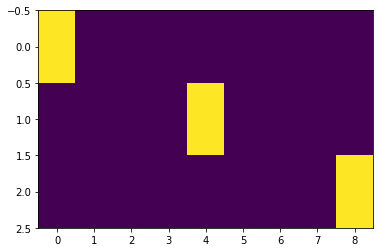

In [13]:
plt.imshow(tl.unfold(S, 0).cpu())
plt.axis("auto")

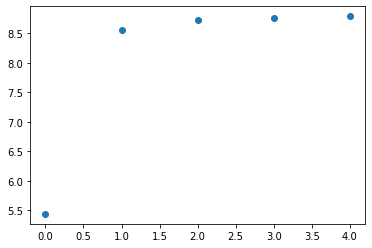

In [14]:
plt.scatter(np.arange(n_iter), dual_objs[0])

In [15]:
X_hat = tl.tenalg.multi_mode_dot(S, A).cpu()
factor_cp = tl.decomposition.non_negative_parafac(X, rank = r[0], init = "svd", n_iter_max = 500)
X_cp = tl.cp_tensor.cp_to_tensor(factor_cp)

(-0.5, 99.5, 1023.5, -0.5)

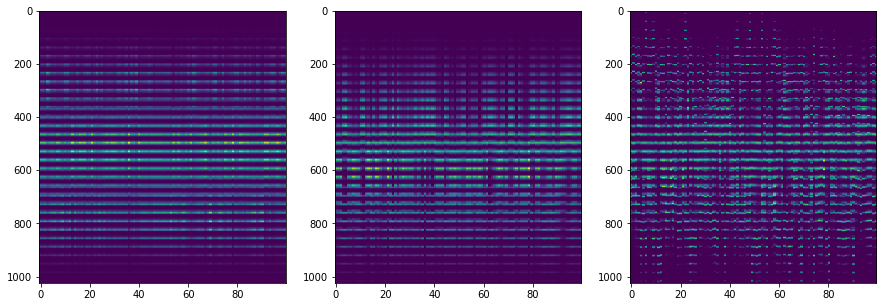

In [16]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_hat.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")
plt.subplot(1, 3, 2)
plt.imshow(X_cp.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")
plt.subplot(1, 3, 3)
plt.imshow(X.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")

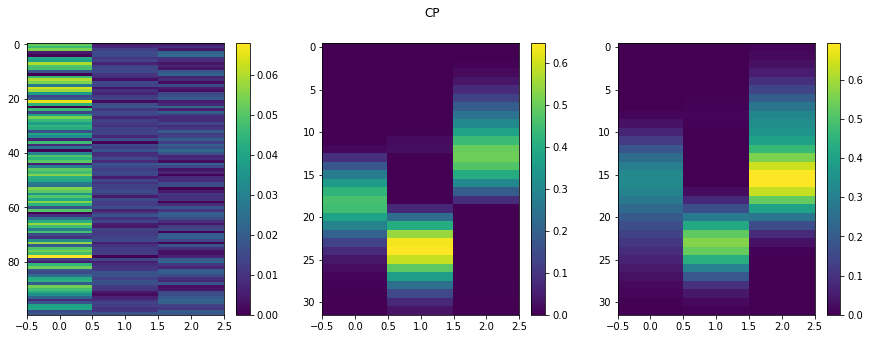

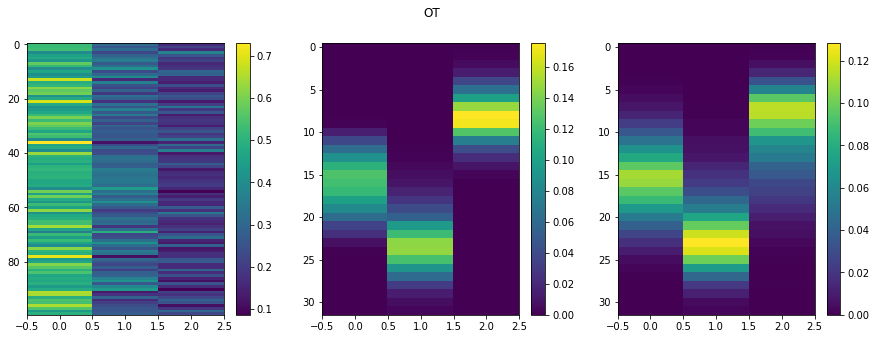

In [17]:
plt.figure(figsize = (15, 5))
plt.suptitle("CP")
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(factor_cp.factors[i], interpolation = "nearest")
    plt.axis("auto")
    plt.colorbar()

plt.figure(figsize = (15, 5))
plt.suptitle("OT")
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(A[i].cpu(), interpolation = "nearest")
    plt.axis("auto")
    plt.colorbar()

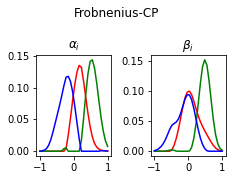

In [43]:
plt.figure(figsize = (4/3*PLT_CELL, PLT_CELL))
plt.suptitle("Frobnenius-CP")
plt.subplot(1, 2, 1)
plt.title("$\\alpha_i$")
plt.plot(np.linspace(-1, 1, 32), wtf.normalise(factor_cp.factors[1][:, 0]), color = "red")
plt.plot(np.linspace(-1, 1, 32), wtf.normalise(factor_cp.factors[1][:, 1]), color = "green")
plt.plot(np.linspace(-1, 1, 32), wtf.normalise(factor_cp.factors[1][:, 2]), color = "blue")
plt.subplot(1, 2, 2)
plt.title("$\\beta_i$")
plt.plot(np.linspace(-1, 1, 32), wtf.normalise(factor_cp.factors[2][:, 0]), color = "red")
plt.plot(np.linspace(-1, 1, 32), wtf.normalise(factor_cp.factors[2][:, 1]), color = "green")
plt.plot(np.linspace(-1, 1, 32), wtf.normalise(factor_cp.factors[2][:, 2]), color = "blue")
plt.tight_layout()
plt.savefig(figs_path + "3mode_slice_atoms_cp.pdf")

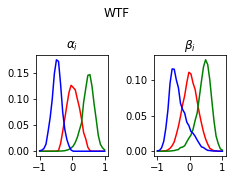

In [42]:
plt.figure(figsize = (4/3*PLT_CELL, PLT_CELL))
plt.subplot(1, 2, 1)
plt.suptitle("WTF")
plt.title("$\\alpha_i$")
plt.plot(np.linspace(-1, 1, 32), A[1][:, 0].cpu(), color = "red")
plt.plot(np.linspace(-1, 1, 32), A[1][:, 1].cpu(), color = "green")
plt.plot(np.linspace(-1, 1, 32), A[1][:, 2].cpu(), color = "blue")
plt.subplot(1, 2, 2)
plt.title("$\\beta_i$")
plt.plot(np.linspace(-1, 1, 32), A[2][:, 0].cpu(), color = "red")
plt.plot(np.linspace(-1, 1, 32), A[2][:, 1].cpu(), color = "green")
plt.plot(np.linspace(-1, 1, 32), A[2][:, 2].cpu(), color = "blue")
plt.tight_layout()
plt.savefig(figs_path + "3mode_slice_atoms_wtf.pdf")

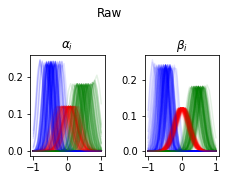

In [44]:
plt.figure(figsize = (4/3*PLT_CELL, PLT_CELL))
plt.suptitle("Raw")
plt.subplot(1, 2, 1)
plt.title("$\\alpha_i$")
for i in range(N):
    plt.plot(np.linspace(-1, 1, 32), wtf.normalise(factors1[i][0]), color = "red", alpha = 0.1)
    plt.plot(np.linspace(-1, 1, 32), wtf.normalise(factors2[i][0]), color = "green", alpha = 0.1)
    plt.plot(np.linspace(-1, 1, 32), wtf.normalise(factors3[i][0]), color = "blue", alpha = 0.1)
plt.subplot(1, 2, 2)
plt.title("$\\beta_i$")
for i in range(N):
    plt.plot(np.linspace(-1, 1, 32), wtf.normalise(factors1[i][1]), color = "red", alpha = 0.1)
    plt.plot(np.linspace(-1, 1, 32), wtf.normalise(factors2[i][1]), color = "green", alpha = 0.1)
    plt.plot(np.linspace(-1, 1, 32), wtf.normalise(factors3[i][1]), color = "blue", alpha = 0.1)
plt.tight_layout()
plt.savefig(figs_path + "3mode_slice_atoms_raw.pdf")

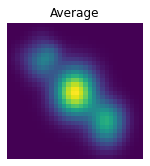

In [26]:
plt.figure(figsize = (PLT_CELL, PLT_CELL))
plt.title("Average")
plt.imshow(X.sum(0))
plt.axis("off")
plt.savefig(figs_path + "3mode_slice_avg.pdf")

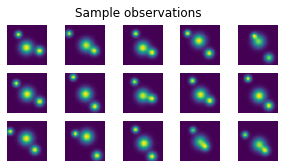

In [27]:
plt.figure(figsize = (2*PLT_CELL, PLT_CELL))
plt.suptitle("Sample observations")
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.axis("off")
    plt.axis("auto")
    plt.imshow(X[i, :, :])
    plt.savefig(figs_path + "3mode_slice_sample.pdf")

In [28]:
d_ot = np.array([ot.emd2(wtf.normalise(X_hat[i, :, :].reshape(-1).double()), wtf.normalise(X[i, :, :].reshape(-1).double()), C_full.cpu()) for i in range(X.shape[0])])
d_baseline = np.array([ot.emd2(wtf.normalise(X_cp[i, :, :].reshape(-1).double()), wtf.normalise(X[i, :, :].reshape(-1).double()), C_full.cpu()) for i in range(X.shape[0])])

In [29]:
d_ot.mean(), d_baseline.mean()

(0.014252544523601265, 0.02416430156019405)

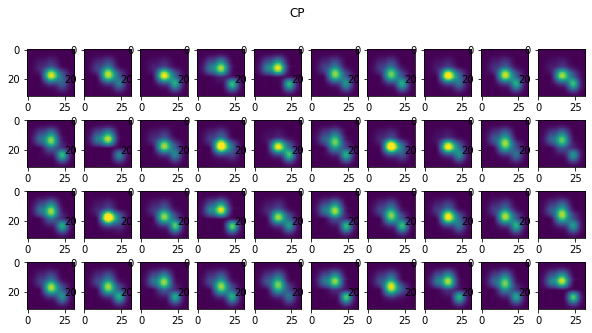

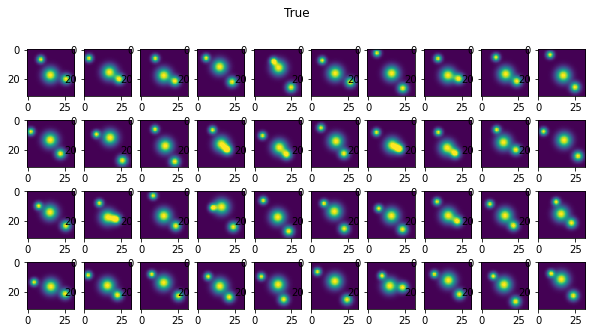

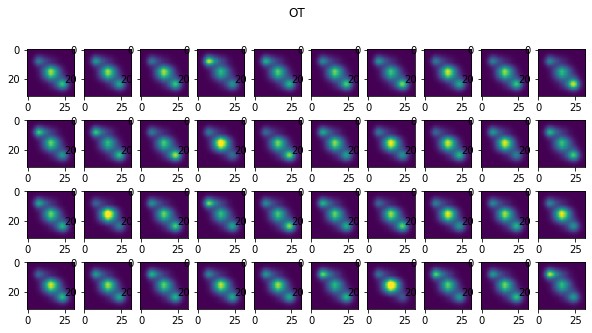

In [30]:
vmax = np.quantile(X, 0.995)
plt.figure(figsize = (10, 5))
plt.suptitle("CP")
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_cp[i, :].reshape(sizex, sizey), vmin = 0, vmax = vmax)

plt.figure(figsize = (10, 5))
plt.suptitle("True")
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X[i, :].reshape(sizex, sizey), vmin = 0, vmax = vmax)

plt.figure(figsize = (10, 5))
plt.suptitle("OT")
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_hat[i, :].reshape(sizex, sizey), vmin = 0, vmax = vmax)

In [31]:
# now try NMF with the same dataset
from sklearn import decomposition
r_nmf = [3, ]*2
S_nmf = tl.zeros(r_nmf).to(device)
for i in range(r_nmf[0]):
    S_nmf[i, i] = 1

X0_nmf = tl.unfold(X, 0).to(device)
nmf_model = sklearn.decomposition.NMF(n_components = r_nmf[0], init = "nndsvd", max_iter = 1)
U_nmf = torch.Tensor(nmf_model.fit_transform(X0_nmf.cpu()))
V_nmf = torch.Tensor(nmf_model.components_)

U_nmf = (U_nmf.T/U_nmf.sum(1)).T
V_nmf = (V_nmf.T/V_nmf.sum(1)).T

A_nmf = copy.deepcopy([U_nmf, V_nmf.T])
A_nmf = [a.to(device) for a in A_nmf]

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [32]:
params_nmf = {"n_iter" : 10}
params_nmf['lr'] = np.ones(params_nmf['n_iter'])*1
params_nmf['lamda'] = np.array([np.ones(2), ]*params_nmf['n_iter'])*25
params_nmf['optim_modes'] = [0, ]
params_nmf['rho'] = np.array([np.ones(2), ]*params_nmf['n_iter'])*0.01
params_nmf['eps'] = np.array([np.ones(2), ]*params_nmf['n_iter'])*0.01

In [33]:
max_iter, print_inter, check_iter, unbal = (100, 10, 10, True)
tol = 1e-3
mode = "lbfgs"
for i in range(params_nmf['n_iter']):
    print("Block iteration ", i)
    print("Mode 0") 
    m0 = wtf.FactorsModel(X0_nmf, 0, [C_full, ], S_nmf, A_nmf, params_nmf['rho'][i, :], params_nmf['eps'][i, :], params_nmf['lamda'][i, :], 
                             ot_mode = "slice", U_init = None, device = device, unbal = unbal, norm = "row")
    wtf.solve(m0, lr = params_nmf['lr'][i], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    A_nmf[0] = m0.compute_primal_variable().detach()
    print("Mode 1") 
    m1 = wtf.FactorsModel(X0_nmf, 1, [C_full, ], S_nmf, A_nmf, params_nmf['rho'][i, :], params_nmf['eps'][i, :], params_nmf['lamda'][i, :], 
                             ot_mode = "slice", U_init = None, device = device, unbal = unbal, norm = "col")
    wtf.solve(m1, lr = params_nmf['lr'][i], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    A_nmf[1] = m1.compute_primal_variable().detach()


Block iteration  0
Mode 0
i = 0 	 dual = 8.919287
i = 10 	 dual = 8.684831
i = 20 	 dual = 8.680985
Mode 1
i = 0 	 dual = 9.017767
i = 10 	 dual = 8.528902
i = 20 	 dual = 8.398905
i = 30 	 dual = 8.364182
i = 40 	 dual = 8.352437
i = 50 	 dual = 8.348724
i = 60 	 dual = 8.347147
Block iteration  1
Mode 0
i = 0 	 dual = 9.138088
i = 10 	 dual = 8.963556
i = 20 	 dual = 8.959707
i = 30 	 dual = 8.958694
Mode 1
i = 0 	 dual = 8.998727
i = 10 	 dual = 8.496408
i = 20 	 dual = 8.386857
i = 30 	 dual = 8.358851
i = 40 	 dual = 8.351580
i = 50 	 dual = 8.349193
i = 60 	 dual = 8.347906
Block iteration  2
Mode 0
i = 0 	 dual = 9.206102
i = 10 	 dual = 9.037581
i = 20 	 dual = 9.034144
i = 30 	 dual = 9.033144
Mode 1
i = 0 	 dual = 8.995768
i = 10 	 dual = 8.479992
i = 20 	 dual = 8.377363
i = 30 	 dual = 8.356629
i = 40 	 dual = 8.351306
i = 50 	 dual = 8.349116
i = 60 	 dual = 8.348090
Block iteration  3
Mode 0
i = 0 	 dual = 9.250264
i = 10 	 dual = 9.079396
i = 20 	 dual = 9.075576
i = 30 

In [34]:
X_hat_nmf = tl.tenalg.multi_mode_dot(S_nmf, A_nmf ).cpu()
nmf_model = sklearn.decomposition.NMF(n_components = r_nmf[0], init = "nndsvd")
U_nmf = torch.Tensor(nmf_model.fit_transform(X0_nmf.cpu()))
V_nmf = torch.Tensor(nmf_model.components_)
X_nmf = U_nmf @ V_nmf

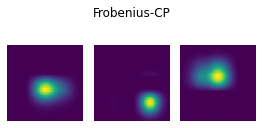

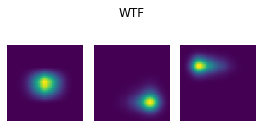

In [36]:
plt.figure(figsize = (PLT_CELL*1.5, 0.75*PLT_CELL))
plt.suptitle("Frobenius-CP")
for i in range(r[0]):
    plt.subplot(1, r[0], i+1)
    plt.imshow(np.outer(factor_cp.factors[1][:, i], factor_cp.factors[2][:, i]))
    plt.axis("off")
plt.tight_layout()
plt.savefig(figs_path + "3mode_slice_atoms2d_cp.pdf")
plt.figure(figsize = (PLT_CELL*1.5, 0.75*PLT_CELL))
plt.suptitle("WTF")
for i in range(r[0]):
    plt.subplot(1, r[0], i+1)
    plt.imshow(np.outer(A[1][:, i].cpu(), A[2][:, i].cpu()))
    plt.axis("off")
plt.tight_layout()
plt.savefig(figs_path + "3mode_slice_atoms2d_wtf.pdf")

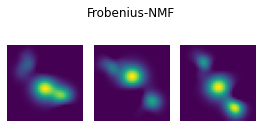

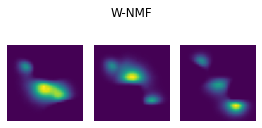

In [37]:
plt.figure(figsize = (PLT_CELL*1.5, 0.75*PLT_CELL))
plt.suptitle("Frobenius-NMF")
for i in range(r[0]):
    plt.subplot(1, r[0], i+1)
    plt.imshow(V_nmf[i, :].reshape(sizex, sizey))
    plt.axis("off")
plt.tight_layout()
plt.savefig(figs_path + "3mode_slice_atoms2d_nmf.pdf")

plt.figure(figsize = (PLT_CELL*1.5, 0.75*PLT_CELL))
plt.suptitle("W-NMF")
for i in range(r[0]):
    plt.subplot(1, r[0], i+1)
    plt.imshow(A_nmf[1][:, i].reshape(sizex, sizey).cpu())
    plt.axis("off") 
plt.tight_layout()
plt.savefig(figs_path + "3mode_slice_atoms2d_wnmf.pdf")